In [22]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
data = pd.read_csv('science_courses_subject_combinations.csv')


In [24]:
data.head()

,Course,Subject Combination,Number of Students (India)
0,Engineering,"Physics, Chemistry, Mathematics, Computer Scie...",500000.0
1,Medicine (MBBS),"Physics, Chemistry, Biology, Mathematics (Opti...",350000.0
2,Biotechnology,"Physics, Chemistry, Biology, Mathematics (Opti...",100000.0
3,Pharmacy,"Physics, Chemistry, Biology or Mathematics",150000.0
4,Computer Science,"Physics, Chemistry, Mathematics, Computer Scie...",450000.0


In [25]:
data_cleaned = data.drop_duplicates()

In [26]:
data_cleaned['Subject Combination'].fillna('No subject combination available', inplace=True)


In [27]:
string_columns = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[string_columns] = data_cleaned[string_columns].apply(lambda x: x.str.strip())


In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()


In [30]:
print("Generating BERT embeddings. This might take some time...")
data_cleaned['Subject_Combination_Embedding'] = data_cleaned['Subject Combination'].apply(get_bert_embeddings)


Generating BERT embeddings. This might take some time...


In [31]:
data_cleaned.to_pickle('processed_data_with_embeddings_.pkl')


In [32]:
knowledge_graph = nx.DiGraph()

In [33]:
for _, row in data_cleaned.iterrows():
    course = row['Course']
    subject_combination = row['Subject Combination'].split(", ")
    
    knowledge_graph.add_node(course, type='course', subject_combination=row['Subject Combination'])
    
    for subject in subject_combination:
        if subject != 'No subject combination available' and subject.strip():
            knowledge_graph.add_edge(subject, course, relationship='subject_combination')


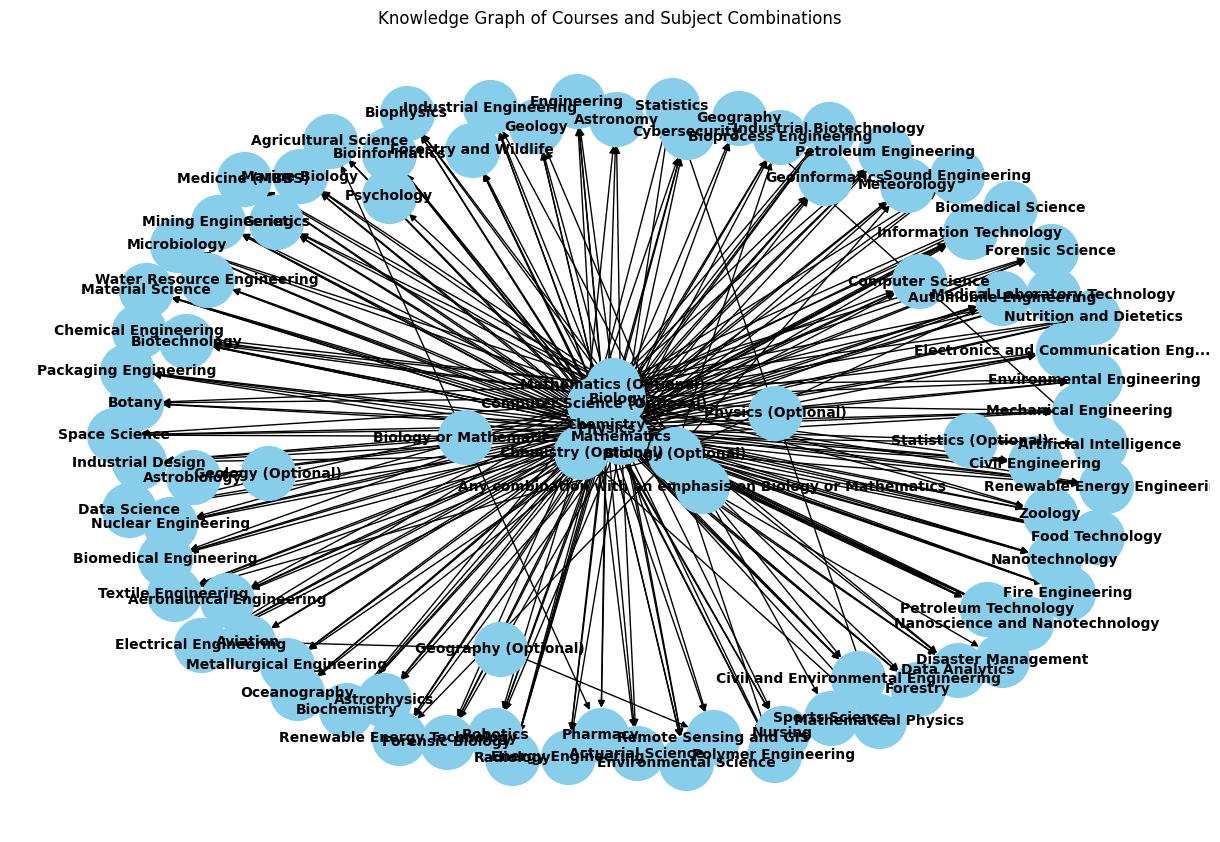

In [34]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, seed=42)
nx.draw(knowledge_graph, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold')
plt.title("Knowledge Graph of Courses and Subject Combinations")
plt.show()

In [35]:
import pickle
with open("knowledge_graph_.gpickle", "wb") as f:
    pickle.dump(knowledge_graph, f)

In [36]:
selected_course = 'Engineering'

subgraph_nodes = list(knowledge_graph.predecessors(selected_course)) + [selected_course]
subgraph = knowledge_graph.subgraph(subgraph_nodes)

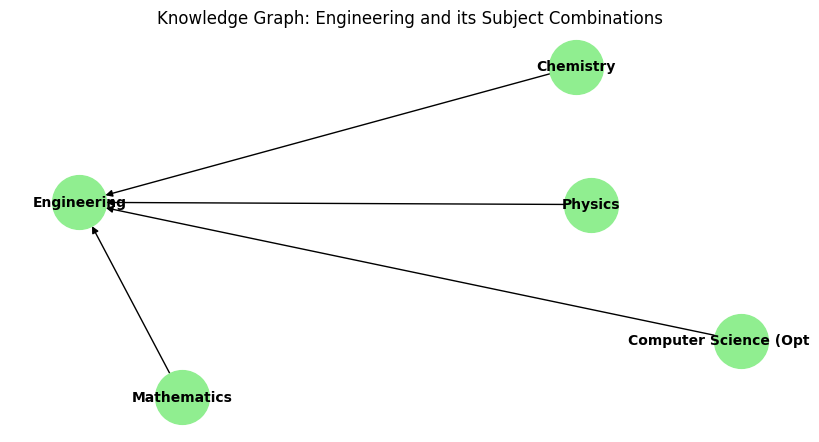

In [42]:
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_color='lightgreen',
    node_size=1500,
    font_size=10,
    font_weight='bold',
)
plt.title(f"Knowledge Graph: {selected_course} and its Subject Combinations")
plt.show()